<a href="https://colab.research.google.com/github/cht123/Left_Center_Right_Model/blob/master/left_center_right_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Left Center Right Monte Carlo Model

The purpose of this notebook is to model the Left Center Right dice game.  The model has two key functions:



*   The first function, run_sim, runs a monte carlo simulation of the game with a specified number of runs, players and dollars per player
*   The second function, run_rand_sim, runs a specified number of simulations with a randomized number of players and dollars per player

The second dataset is then used to build a model to estimate the number of turns in a game given a specified number of players and dolalrs per player.



#Imports

In [0]:
import pandas as pd
from random import choice
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict

#Game functions

In [0]:
def roll_dice(dice):

  '''Roll the dice for the round'''

  d1_pos = choice(dice)
  d2_pos = choice(dice)
  d3_pos = choice(dice)

  return d1_pos, d2_pos, d3_pos

In [0]:
def pay(turn, player, player_bank, player_moves):

  '''Determine actions once the dice are rolled'''

  l_player = player_moves[player][1][0]
  r_player = player_moves[player][1][1]
  l_player_add = 0
  r_player_add = 0
  pot_add = 0
  roll = 0

  # determine how many dice should be rolled
  if player_bank[player] >2:
    roll = 3
  elif player_bank[player] ==2:
    roll = 2
  elif player_bank[player] ==1:
    roll = 1
  else:
    roll = 0
  
  # pay the players and pot based on the roll of the dice
  for i in range(roll):
    if turn[i] == 'R':
      r_player_add = r_player_add + 1
    elif turn[i] == 'L':
      l_player_add = l_player_add + 1
    elif turn[i] == 'C':
      pot_add = pot_add + 1
    else:
      None
      
  return l_player, l_player_add, r_player, r_player_add, pot_add

In [0]:
def print_begin(p, player_bank, pot):
  
  '''Print the player and amount in pot at the beginning of the round'''

  print('------------------------------------------------------------------------------')
  print('Player {} is rolling and has {}'.format(p, player_bank[p]))
  print('The pot is at {}'.format(pot))

In [0]:
def print_end(turn, pot, player_bank, nz_player_bank, turn_count):

  '''Print the state of the game at the end of the roll'''

  print('The dice are: {}'.format(turn))
  print('The pot ends at {}'.format(pot))
  print('The player bank is: {}'.format(player_bank))
  print('The nonzero bank is: {}'.format(nz_player_bank))
  print('{} players still have money'.format(len(nz_player_bank)))
  print('Round: {}'.format(turn_count))
  

In [0]:
def run_game(sim, player_count, dollars):

  '''Run a simulation of the game given a specified number of players and dolalrs per player'''
  
  # initialize an empty dataframe that will store the result of all the simulaitons
  game_detail = pd.DataFrame(columns=['turn_count', 'player', 'dice_1', 'dice_2', 'dice_3', 'pot'])
  
  # define the dice used in the game
  dice = ['L', 'R', 'C', 'DOT', 'DOT', 'DOT']
  
  # initiatlize the pot 
  pot = 0
  
  # initialize the rounds
  turn_count = 0

  # initialize the list that will store each game's data
  all_turn_data = []
  
  # create a list of players based on the player_count parameter
  player = [i for i in range(0,player_count)]

  # create a dictionary 'bank' for the players, the value is initiated as the dolalrs input parameter  
  player_bank = {i:dollars for i in range(0,player_count)}

  # create a list of all possible moves by players based on player_count input parameter
  player_moves = [[i, [player[player.index(i)-1], 0]] if i == player_count -1 else [i, [player[player.index(i)-1], player.index(i)+1]] for i in player]

  # initialize the simulation
  running = True

  # run the simulation
  while running:
    
    for p in player:
      
      # only used for debugging
      # print_begin(p, player_bank, pot)
      turn_data = []
      

      if player_bank[p] > 0:

        turn_count+=1
        
        # roll the dice
        turn = roll_dice(dice)
        
        # determine who paid gets paid and how much
        dist = player_moves[p]
        result = pay(turn, p, player_bank, player_moves)
        
        # distribute money
        player_bank[result[0]] = player_bank[result[0]] + result[1]
        player_bank[result[2]] = player_bank[result[2]] + result[3]
        pot = pot + result[4]
        player_bank[p] = player_bank[p] - (result[1] + result[3] + result[4])
        nz_player_bank = {k:v for (k,v) in player_bank.items() if v>0}
        
      
      # only used for debugging
      # print_end(turn, pot, player_bank, nz_player_bank, turn_count)

      # create a list of the outputs of turn
      turn_data = [sim, player_count, dollars, turn_count, pot, player_count * dollars]

      
      all_turn_data.append(turn_data)
      
      if len(nz_player_bank) == 1:
        running = False
        break

  return all_turn_data

In [0]:
def run_sim(s, p, d):

  '''Run the game for a specified numer of times for a given number of players and dollars'''
  
  sim_data = []

  for r in range(s):
    data = run_game(r,p,d)
    sim_data.append(data)
    
  return sim_data

In [0]:
# run the simulation
big_sim = run_sim(50000, 20, 5)

In [0]:
def convert_list(input_list):

  '''Conver the output list from the simulation to a dataframe'''

  k = []

  for i in range(len(input_list)):
    for j in range(len(input_list[i])):
      k.append(input_list[i][j])
  data_df = pd.DataFrame(data = k, columns = ['sim', 'player_count', 'dollars', 'turn_count', 'pot', 'total_dollars'])

  return data_df

In [0]:
data_df = convert_list(big_sim)

In [0]:
# keep only the last record of each simulated game to create the data for the histogram and stats
hist_data = data_df.sort_values('turn_count').drop_duplicates(['sim'],keep='last')

(array([9.0000e+01, 1.5470e+03, 9.1760e+03, 1.7248e+04, 1.4217e+04,
        6.1430e+03, 1.3630e+03, 1.9900e+02, 1.5000e+01, 2.0000e+00]),
 array([175. , 201.4, 227.8, 254.2, 280.6, 307. , 333.4, 359.8, 386.2,
        412.6, 439. ]),
 <a list of 10 Patch objects>)

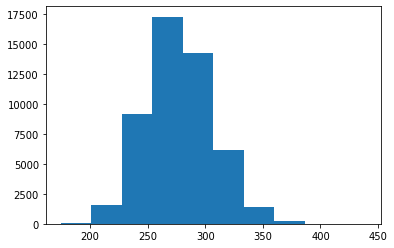

In [110]:
plt.hist(hist_data['turn_count'])

In [0]:
mean = hist_data['turn_count'].mean()
median = hist_data['turn_count'].median()
min = hist_data['turn_count'].min()
max = hist_data['turn_count'].max()
std = hist_data['turn_count'].std()
UCL = mean + 3 * std
LCL = mean - 3 * std

In [106]:
print('Mean: {}'.format(mean))
print('Median: {}'.format(median))
print('Min: {}'.format(min))
print('Max: {}'.format(max))
print('Std: {}'.format(std))
print('UCL: {}'.format(UCL))
print('LCL: {}'.format(LCL))

Mean: 277.27896
Median: 276.0
Min: 175
Max: 439
Std: 28.628854212913918
UCL: 363.1655226387417
LCL: 191.39239736125825


# Run random games to build a model

In [0]:
def run_rand_sim(s, p, d):

  '''Run simulated games with random number of players and dollars'''

  sim_data = []

  # require at least two players and 2 dollars
  if p < 3 or d < 2:
    print('Players must be greater than 2 and dollars must be greater than 1')
  
  else:

    for r in range(s):
      # get random player and dollar counts
      prand = choice(range(2,p))
      drand = choice(range(1,d))
      data = run_game(r,prand,drand)
      sim_data.append(data)
    
  return sim_data

In [0]:
# run the random simulations
rand_sim = run_rand_sim(10000, 20, 10)

In [0]:
# convert the output list to a dataframe
rand_data_df = convert_list(rand_sim)

In [0]:
# keep only the last record of each simulation to create the dataset for the model
rand_hist_data = rand_data_df.sort_values('turn_count').drop_duplicates(['sim'],keep='last')

In [89]:
# take a look at the data
rand_hist_data.head(3)

,sim,player_count,dollars,turn_count,pot,total_dollars
67184,334,2,1,1,1,2
1285816,6346,2,2,1,1,4
1326342,6535,2,1,1,0,2


In [0]:
rand_hist_agg = rand_hist_data.groupby(['player_count', 'dollars'])['turn_count'].mean().reset_index()

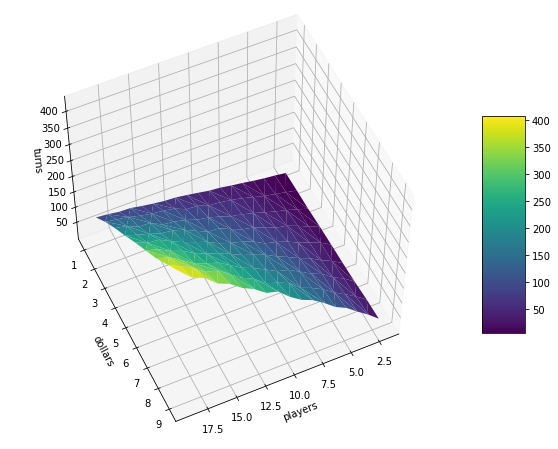

In [115]:
# Make the plot
fig = plt.figure(figsize=(10, 8))
ax = fig.gca(projection='3d')
surf = ax.plot_trisurf(rand_hist_agg['player_count'], rand_hist_agg['dollars'], rand_hist_agg['turn_count'], cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar( surf, shrink=0.5, aspect=5)
ax.view_init(55, 65)
ax.set_xlabel('players')
ax.set_ylabel('dollars')
ax.set_zlabel('turns')
plt.show()

#Split train/ test

In [0]:
# get the featuers and labels
X = rand_hist_data.iloc[:,1:3]
y = rand_hist_data.iloc[:, 3]

In [0]:
# create the train/test data sets
x_training_set, x_test_set, y_training_set, y_test_set = train_test_split(X,y,test_size=0.10, random_state=7, shuffle=True)

# Fit the model

In [94]:
# fit the regression model
model = RandomForestRegressor(random_state=0)
model.fit(x_training_set, y_training_set)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [95]:
# calculate the R2
model_score = model.score(x_training_set,y_training_set)
print('Coefficient of determination R^2 of the prediction: {}'.format(round(model_score,2)))
y_predicted = model.predict(x_test_set)

# calculate mean squared error
print("Mean squared error: %.2f"% mean_squared_error(y_test_set, y_predicted))
print('Test Variance score: %.2f' % r2_score(y_test_set, y_predicted))

# calculate mean absolute error
errors = abs(y_predicted - y_test_set)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'rounds.')

Coefficient of determination R^2 of the prediction: 0.96
Mean squared error: 439.86
Test Variance score: 0.96
Mean Absolute Error: 15.71 rounds.


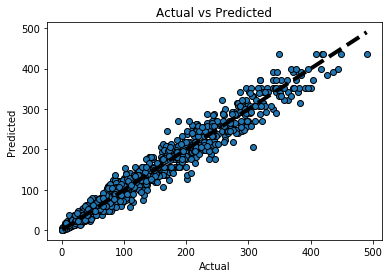

In [96]:
# create a scatterplot of the Actual vs. Predicted values
fig, ax = plt.subplots()

ax.scatter(y_test_set, y_predicted, edgecolors=(0, 0, 0))

ax.plot([y_test_set.min(), y_test_set.max()], [y_test_set.min(), y_test_set.max()], 'k--', lw=4)

ax.set_xlabel('Actual')

ax.set_ylabel('Predicted')

ax.set_title("Actual vs Predicted")

plt.show()

# Compare output of the model and the montecarlo simulation

In [97]:
num_players = input('Enter the number of players: ')

Enter the number of players: 20


In [98]:
num_dollars = input('Enter the number of dollars: ')

Enter the number of dollars: 5


In [99]:
# run the model
model.predict(pd.DataFrame([[num_players,num_dollars]]))

array([262.41078216])

In [0]:
# From monte carlo with 20 players and 5 dollars
Mean: 277.27896
Median: 276.0
Min: 175
Max: 439
Std: 28.628854212913918
UCL: 363.1655226387417
LCL: 191.39239736125825